# Part 1: Exploratory Data Analysis and Data Preprocessing

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import joblib
from sklearn.model_selection import learning_curve
from scipy import stats

In [122]:
# Load the dataset
df = pd.read_csv('Salary Data.csv')

In [123]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (375, 6)


In [124]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB
None


In [125]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
              Age  Years of Experience         Salary
count  373.000000           373.000000     373.000000
mean    37.431635            10.030831  100577.345845
std      7.069073             6.557007   48240.013482
min     23.000000             0.000000     350.000000
25%     31.000000             4.000000   55000.000000
50%     36.000000             9.000000   95000.000000
75%     44.000000            15.000000  140000.000000
max     53.000000            25.000000  250000.000000


In [126]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64


In [127]:
# Handle missing values
# Drop rows with empty strings in all columns
df = df.replace('', np.nan)
df = df.dropna()

In [128]:
# Convert numeric columns
df['Age'] = pd.to_numeric(df['Age'])
df['Years of Experience'] = pd.to_numeric(df['Years of Experience'])
df['Salary'] = pd.to_numeric(df['Salary'])

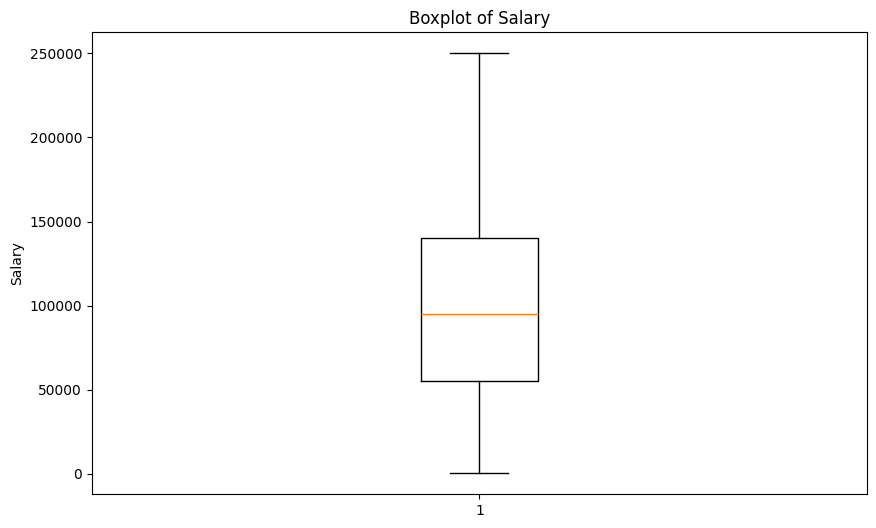

In [129]:
# Check for outliers in salary
plt.figure(figsize=(10, 6))
plt.boxplot(df['Salary'])
plt.title('Boxplot of Salary')
plt.ylabel('Salary')
plt.show()

In [130]:
# Fixing anomalies in the data
# Checking for extremely low salaries (possible data entry errors)
print("\nRows with very low salaries:")
print(df[df['Salary'] < 1000])


Rows with very low salaries:
      Age Gender Education Level                           Job Title  \
259  29.0   Male      Bachelor's  Junior Business Operations Analyst   

     Years of Experience  Salary  
259                  1.5   350.0  


In [131]:
# Removes rows with clearly incorrect salaries ( the row 259 $350 annual salary is likely an error)
df = df[df['Salary'] > 1000]

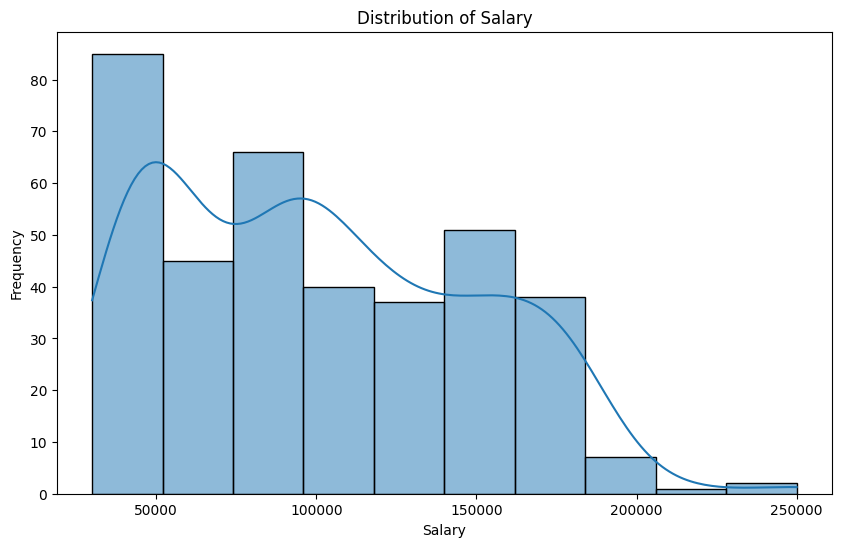

In [132]:
# Visualize the distribution of salary
plt.figure(figsize=(10, 6))
sns.histplot(df['Salary'], kde=True)
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

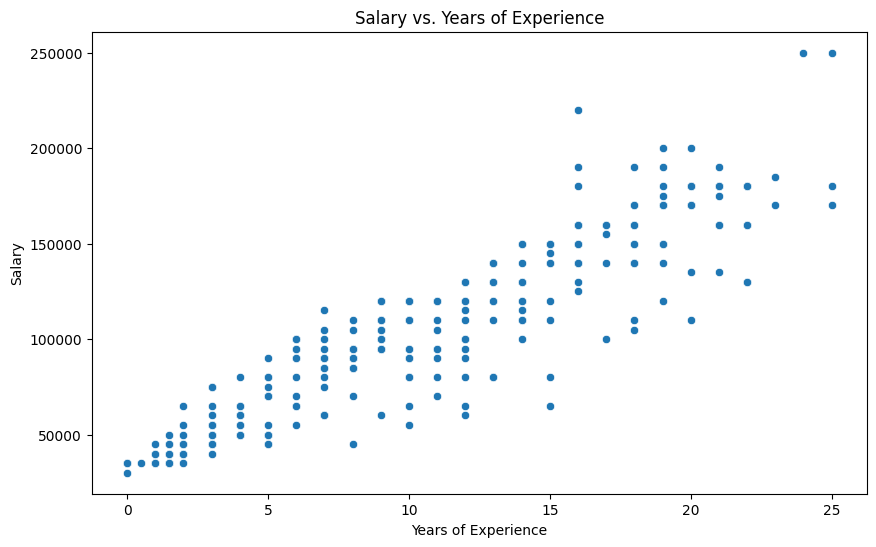

In [133]:
# Visualize the relationship between Years of Experience and Salary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Years of Experience', y='Salary', data=df)
plt.title('Salary vs. Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()


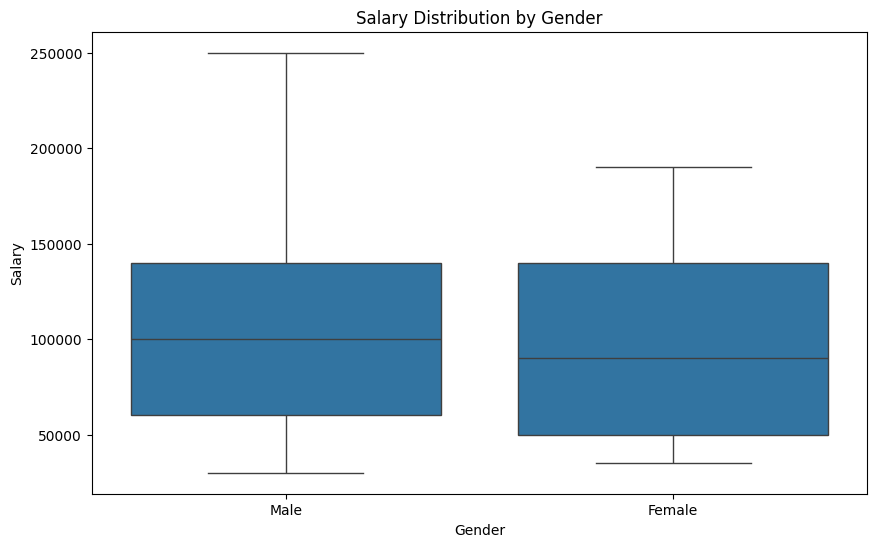

In [134]:
# Visualize salary by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Salary', data=df)
plt.title('Salary Distribution by Gender')
plt.show()

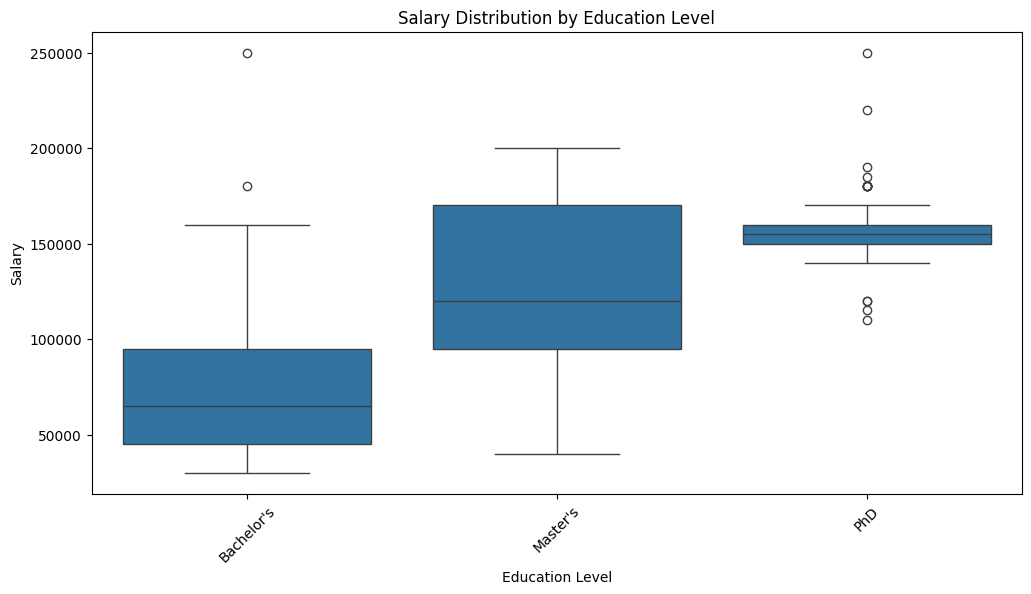

In [135]:
# Visualize salary by education level
plt.figure(figsize=(12, 6))
sns.boxplot(x='Education Level', y='Salary', data=df)
plt.title('Salary Distribution by Education Level')
plt.xticks(rotation=45)
plt.show()

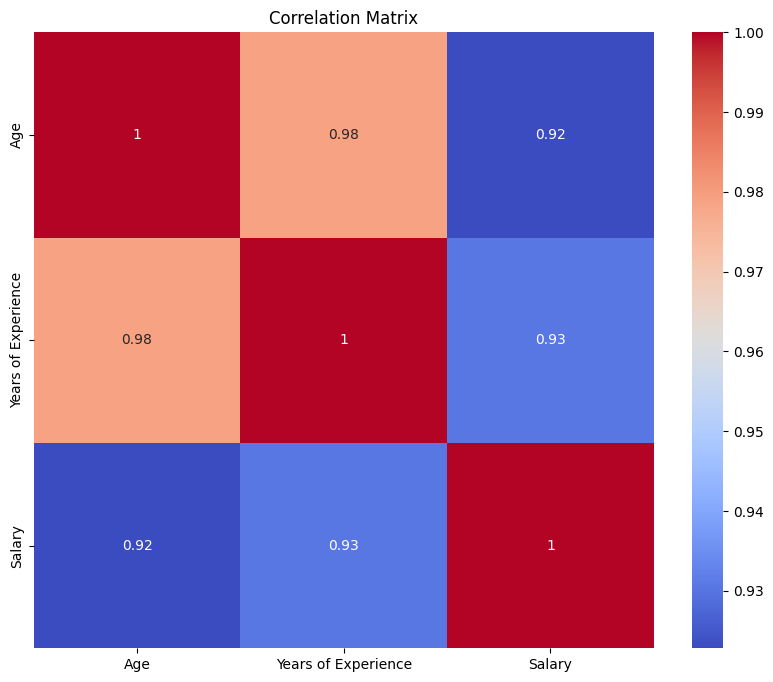

In [136]:
# Correlation analysis
numeric_cols = ['Age', 'Years of Experience', 'Salary']
correlation = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [137]:
# Creates features and target variables
X = df.drop('Salary', axis=1)
y = df['Salary']

In [138]:
# Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (297, 5)
Testing set shape: (75, 5)


In [139]:
# Saves processed data for next steps
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

print("\nData preprocessing completed and ready for feature engineering.")


Data preprocessing completed and ready for feature engineering.


# Part 2: Feature Engineering and Model Selection

In [140]:
# 1. Create a preprocessing pipeline for categorical features
categorical_features = ['Gender', 'Education Level', 'Job Title']
numerical_features = ['Age', 'Years of Experience']

In [141]:
# For categorical features, use one-hot encoding 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [142]:
# For numerical features, use standard scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [143]:

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return y_pred, mse, rmse, mae, r2

In [144]:
# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Create pipelines for each model
model_pipelines = {}
model_results = {}

# Process the data and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Store the pipeline
    model_pipelines[name] = pipeline
    
    # Evaluate the model
    y_pred, mse, rmse, mae, r2 = evaluate_model(pipeline, X_train, X_test, y_train, y_test)
    model_results[name] = {
        'y_pred': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Find the best performing model based on R² score
best_model = max(model_results.items(), key=lambda x: x[1]['r2'])
print(f"\nBest performing model: {best_model[0]} with R² score: {best_model[1]['r2']:.4f}")


--- Evaluating Linear Regression ---
Mean Squared Error: 380198506.83
Root Mean Squared Error: 19498.68
Mean Absolute Error: 12273.50
R² Score: 0.8507

--- Evaluating Ridge Regression ---
Mean Squared Error: 218032010.68
Root Mean Squared Error: 14765.91
Mean Absolute Error: 9314.93
R² Score: 0.9144

--- Evaluating Lasso Regression ---
Mean Squared Error: 370366503.91
Root Mean Squared Error: 19244.91
Mean Absolute Error: 11735.51
R² Score: 0.8545

--- Evaluating Random Forest ---
Mean Squared Error: 294663360.59
Root Mean Squared Error: 17165.76
Mean Absolute Error: 9746.58
R² Score: 0.8843

--- Evaluating Gradient Boosting ---
Mean Squared Error: 314870158.75
Root Mean Squared Error: 17744.58
Mean Absolute Error: 10126.96
R² Score: 0.8763

Best performing model: Ridge Regression with R² score: 0.9144


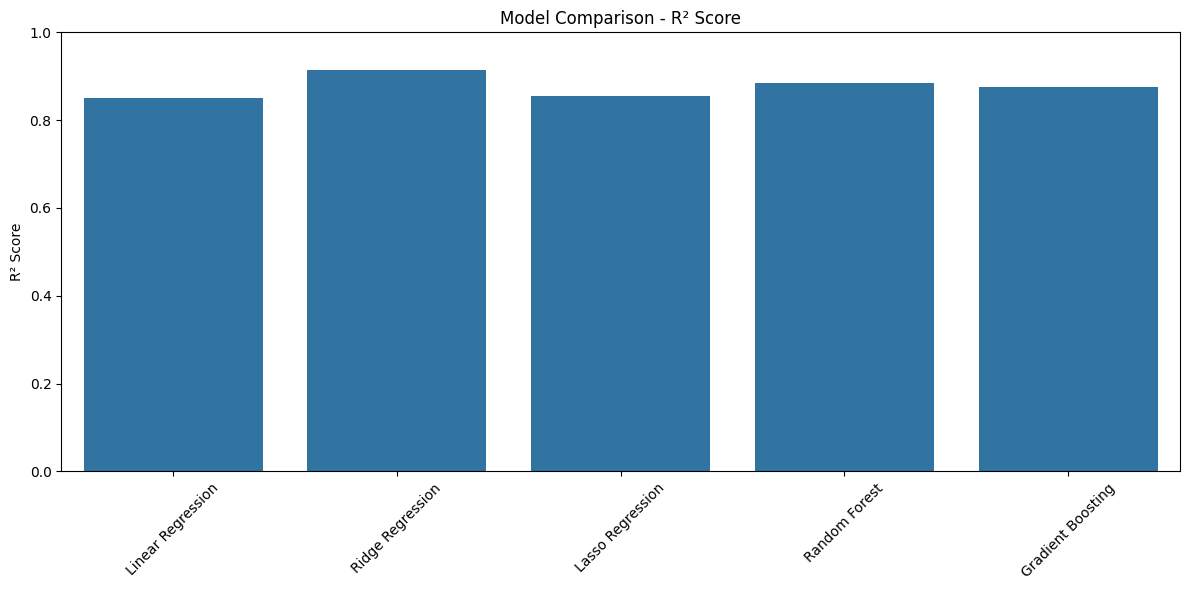

In [145]:
# Visualize model performance comparison
plt.figure(figsize=(12, 6))
model_names = list(model_results.keys())
r2_scores = [model_results[name]['r2'] for name in model_names]

sns.barplot(x=model_names, y=r2_scores)
plt.title('Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:
# Save the best model for hyperparameter tuning
best_model_name = best_model[0]
best_pipeline = model_pipelines[best_model_name]

print(f"\nSelected {best_model_name} for hyperparameter tuning in the next step.")


Selected Ridge Regression for hyperparameter tuning in the next step.


# Part 3: Model Hyperparameter Tuning

Tuning hyperparameters for Ridge Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'model__alpha': 1.0}
Best cross-validation R² score: 0.9032

--- Evaluating Tuned Model ---
Mean Squared Error: 218032010.68
Root Mean Squared Error: 14765.91
Mean Absolute Error: 9314.93
R² Score: 0.9144

--- Model Comparison ---
Original Ridge Regression R² Score: 0.9144
Tuned Ridge Regression R² Score: 0.9144
Improvement: 0.0000


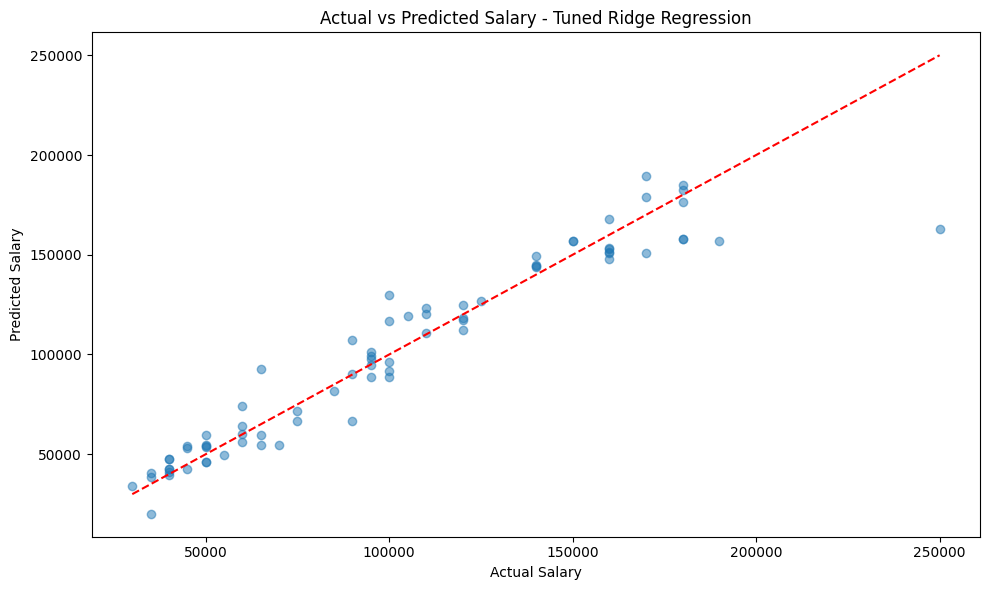

In [147]:
# Function to tune hyperparameters for different models
def tune_hyperparameters(model_name, pipeline, X_train, y_train):
    print(f"Tuning hyperparameters for {model_name}...")
    
    param_grid = {}
    
    if model_name == 'Linear Regression':
        # Linear Regression has no hyperparameters to tune
        return pipeline
    
    elif model_name == 'Ridge Regression':
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    
    elif model_name == 'Lasso Regression':
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        }
    
    elif model_name == 'Random Forest':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    
    elif model_name == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5],
            'model__subsample': [0.8, 0.9, 1.0]
        }
    
    # Create grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Tune hyperparameters for the best model
best_tuned_model = tune_hyperparameters(best_model_name, best_pipeline, X_train, y_train)

# Evaluate the tuned model
print("\n--- Evaluating Tuned Model ---")
y_pred_tuned, mse_tuned, rmse_tuned, mae_tuned, r2_tuned = evaluate_model(
    best_tuned_model, X_train, X_test, y_train, y_test
)

# Compare original vs tuned model
print("\n--- Model Comparison ---")
print(f"Original {best_model_name} R² Score: {best_model[1]['r2']:.4f}")
print(f"Tuned {best_model_name} R² Score: {r2_tuned:.4f}")
print(f"Improvement: {r2_tuned - best_model[1]['r2']:.4f}")

# Visualize actual vs predicted salary for the tuned model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Actual vs Predicted Salary - Tuned {best_model_name}')
plt.tight_layout()
plt.show()

# Feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get the preprocessor from the pipeline
    preprocessor = best_tuned_model.named_steps['preprocessor']
    model = best_tuned_model.named_steps['model']
    
    # Get feature names after preprocessing
    cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([numerical_features, cat_features])
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importances - {best_model_name}')
    plt.bar(range(len(indices[:15])), importances[indices[:15]], align='center')
    plt.xticks(range(len(indices[:15])), [feature_names[i] for i in indices[:15]], rotation=90)
    plt.tight_layout()
    plt.show()



In [148]:
# Save the final model for deployment
final_model = best_tuned_model
print("\nModel optimization completed. Ready for final evaluation and deployment.")


Model optimization completed. Ready for final evaluation and deployment.


# Part 4: Model Evaluation and Deployment

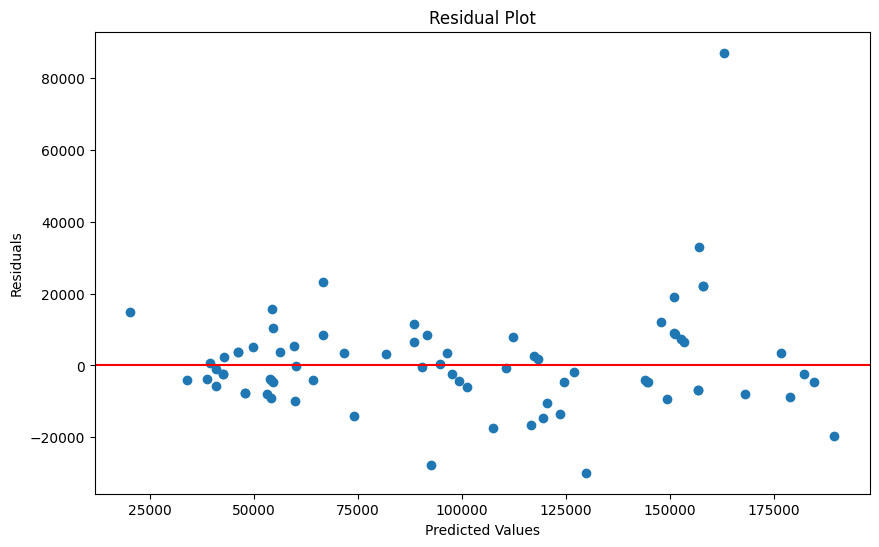

In [149]:
# Calculate residuals
y_pred_final = final_model.predict(X_test)
residuals = y_test - y_pred_final

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

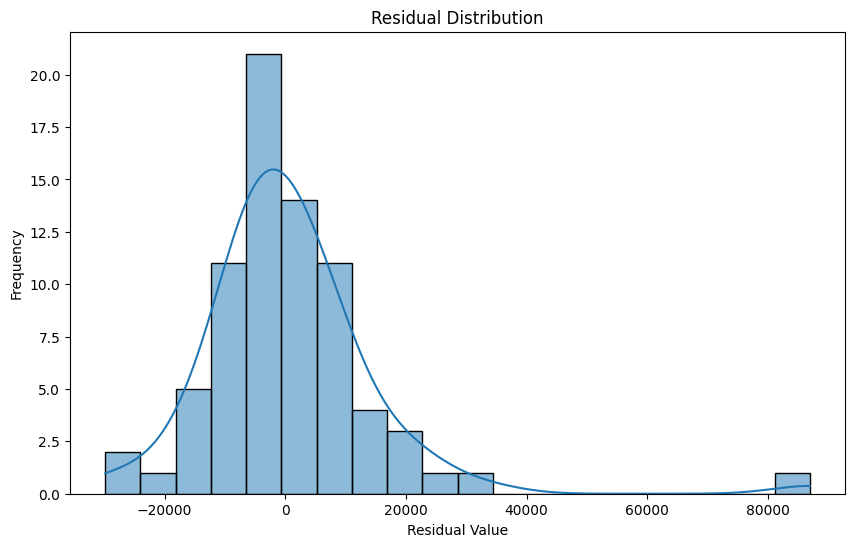

In [150]:
# Plot residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

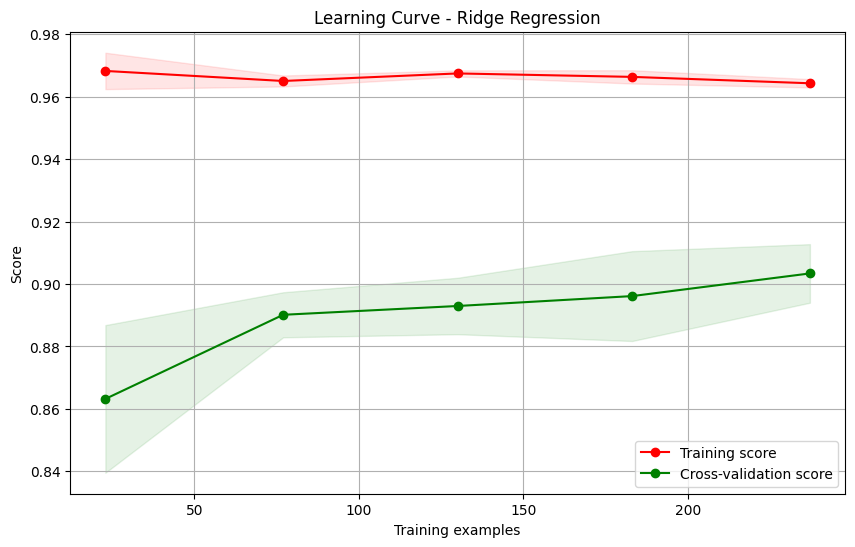

In [151]:
# Plot learning curves to check for overfitting/underfitting
def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="r2")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

# Plot learning curve
plot_learning_curve(final_model, X_train, y_train, title=f"Learning Curve - {best_model_name}")
plt.show()

In [152]:
# Compute confidence intervals on test set performance

# Function to calculate 95% confidence interval for R²
def r2_confidence_interval(y_true, y_pred, confidence=0.95):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    
    # Fisher transformation of R²
    z = 0.5 * np.log((1 + np.sqrt(r2)) / (1 - np.sqrt(r2)))
    
    # Standard error of z
    se = 1 / np.sqrt(n - 3)
    
    # Confidence interval for z
    z_lower = z - stats.norm.ppf(1 - (1 - confidence) / 2) * se
    z_upper = z + stats.norm.ppf(1 - (1 - confidence) / 2) * se
    
    # Back-transform to R²
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return r2, r_lower**2, r_upper**2

# Calculate confidence interval for R²
r2, r2_lower, r2_upper = r2_confidence_interval(y_test, y_pred_final)
print(f"R² Score: {r2:.4f}")
print(f"95% Confidence Interval for R²: [{r2_lower:.4f}, {r2_upper:.4f}]")

R² Score: 0.9144
95% Confidence Interval for R²: [0.8675, 0.9452]


In [153]:
# Function for sample salary predictions
def predict_salary(model, age, gender, education, job_title, experience):
    # Create a sample input dataframe
    input_data = pd.DataFrame({
        'Age': [age],
        'Gender': [gender],
        'Education Level': [education],
        'Job Title': [job_title],
        'Years of Experience': [experience]
    })
    
    # Make prediction
    salary_prediction = model.predict(input_data)[0]
    
    return salary_prediction

# Example predictions
print("\nSample Predictions:")
sample_profiles = [
    {'age': 30, 'gender': 'Male', 'education': "Bachelor's", 'job_title': 'Software Engineer', 'experience': 5},
    {'age': 35, 'gender': 'Female', 'education': "Master's", 'job_title': 'Data Scientist', 'experience': 7},
    {'age': 45, 'gender': 'Male', 'education': "PhD", 'job_title': 'Senior Manager', 'experience': 15},
    {'age': 28, 'gender': 'Female', 'education': "Bachelor's", 'job_title': 'Marketing Analyst', 'experience': 3}
]

for i, profile in enumerate(sample_profiles):
    salary = predict_salary(final_model, 
                           profile['age'], 
                           profile['gender'], 
                           profile['education'], 
                           profile['job_title'], 
                           profile['experience'])
    print(f"Profile {i+1}: {profile['gender']} {profile['job_title']} with {profile['experience']} years experience, {profile['education']} degree, {profile['age']} years old")
    print(f"Predicted Salary: ${salary:.2f}")
    print()


Sample Predictions:
Profile 1: Male Software Engineer with 5 years experience, Bachelor's degree, 30 years old
Predicted Salary: $59761.85

Profile 2: Female Data Scientist with 7 years experience, Master's degree, 35 years old
Predicted Salary: $93320.50

Profile 3: Male Senior Manager with 15 years experience, PhD degree, 45 years old
Predicted Salary: $154442.27

Profile 4: Female Marketing Analyst with 3 years experience, Bachelor's degree, 28 years old
Predicted Salary: $41252.15



In [154]:
# Save the final model
joblib.dump(final_model, 'salary_prediction_model.pkl')
print("Model saved as 'salary_prediction_model.pkl'")

Model saved as 'salary_prediction_model.pkl'
